# Real-Time Stock Analysis & Price Movement Prediction of NVIDIA
This project analyzes NVIDIA's stock trends and attempts to predict next-day closing prices using machine learning.

**Skills Demonstrated**
- Python (Pandas, NumPy, Scikit-learn)
- API Integration (`yfinance`)
- SQL (via SQLite)
- Data Visualization (Matplotlib)
- Financial Feature Engineering
- Machine Learning (Linear Regression)


# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import re
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

# Fetch Real-Time NVIDIA Stock Data

In [2]:
ticker = "NVDA"
nvidia_data = yf.download(ticker, period="1y", interval="1d")
nvidia_data.reset_index(inplace=True)
nvidia_data.rename(columns={'Date':'date', 'Open':'open', 'High':'high', 
                            'Low':'low', 'Close':'close', 'Adj Close':'adj_close', 
                            'Volume':'volume'}, inplace=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_18068\4119291607.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nvidia_data = yf.download(ticker, period="1y", interval="1d")
[*********************100%***********************]  1 of 1 completed


In [3]:
print("Data fetched successfully from Yahoo Finance!")
display(nvidia_data.head())


Data fetched successfully from Yahoo Finance!


Price,date,close,high,low,open,volume
Ticker,,NVDA,NVDA,NVDA,NVDA,NVDA
0,2024-11-07,148.837341,148.887315,146.128111,146.348049,207323300
1,2024-11-08,147.587677,149.727063,146.218059,148.727350,175665800
2,2024-11-11,145.218353,148.807336,143.528851,148.637371,182325600
3,2024-11-12,148.247467,149.607078,145.968122,146.737906,198634700
4,2024-11-13,146.228058,149.287178,145.858154,149.027258,191903300


# Saving to SQL Database

In [4]:
# Connect to your database
conn = sqlite3.connect("nvidia_stock.db")
# Load the data (even though columns are weird)
df = pd.read_sql("SELECT * FROM nvidia_stock;", conn)
# Cleaning columns
def clean_col(col):
    # If the column is like "('close', 'NVDA')" or "('date', '')"
    if isinstance(col, str):
        col = re.sub(r"[\(\)'\",]", "", col)  # remove brackets, quotes, commas
        parts = [x.strip() for x in col.split() if x.strip()]
        if len(parts) > 0:
            return parts[0].lower()
    return str(col).lower()

df.columns = [clean_col(c) for c in df.columns]

print("Cleaned columns:")
print(df.columns.tolist())

Cleaned columns:
['date', 'close', 'high', 'low', 'open', 'volume']


In [5]:
# Overwrite table with cleaned version
df.to_sql("nvidia_stock", conn, if_exists="replace", index=False)
conn.close()
print("\n SQL table successfully rewritten with clean column names!")


 SQL table successfully rewritten with clean column names!


In [6]:
conn = sqlite3.connect("nvidia_stock.db")
print(pd.read_sql("PRAGMA table_info(nvidia_stock);", conn))
conn.close()

   cid    name     type  notnull dflt_value  pk
0    0    date     TEXT        0       None   0
1    1   close     REAL        0       None   0
2    2    high     REAL        0       None   0
3    3     low     REAL        0       None   0
4    4    open     REAL        0       None   0
5    5  volume  INTEGER        0       None   0


In [7]:
conn = sqlite3.connect("nvidia_stock.db")
df_latest = pd.read_sql("SELECT date, close, volume FROM nvidia_stock ORDER BY date DESC LIMIT 5;", conn)
conn.close()
print(df_latest)

                  date       close     volume
0  2025-10-31 00:00:00  202.490005  179485000
1  2025-10-30 00:00:00  202.889999  178864400
2  2025-10-29 00:00:00  207.039993  308829600
3  2025-10-28 00:00:00  201.029999  297986200
4  2025-10-27 00:00:00  191.490005  153452700


# SQL Query

In [8]:
conn = sqlite3.connect("nvidia_stock.db")
top_5_highestvolume = pd.read_sql("SELECT date, close, volume FROM nvidia_stock ORDER BY volume DESC LIMIT 5", conn)
print("\n Top 5 Highest Volume Trading Days:")
display(top_5_highestvolume,conn)


 Top 5 Highest Volume Trading Days:


,date,close,volume
0,2025-01-27 00:00:00,118.394203,818830900
1,2025-04-09 00:00:00,114.315613,612918300
2,2025-04-07 00:00:00,97.627708,611041300
3,2025-01-28 00:00:00,128.961914,579666400
4,2025-04-04 00:00:00,94.298134,532273800


# Feature Engineering

In [9]:
df = nvidia_data.copy()
df['Daily_Return'] = df['close'].pct_change()
df['MA_7'] = df['close'].rolling(window=7).mean()
df['MA_30'] = df['close'].rolling(window=30).mean()
df['Volatility'] = df['Daily_Return'].rolling(window=7).std()
df.dropna(inplace=True)
print("Feature Engineering Complete")
display(df.head())

Feature Engineering Complete


Price,date,close,high,low,open,volume,Daily_Return,MA_7,MA_30,Volatility
Ticker,,NVDA,NVDA,NVDA,NVDA,NVDA,,,,
29,2024-12-19,130.651520,134.000796,129.521776,131.731286,209719200,0.013730,133.239541,140.348516,0.019553
30,2024-12-20,134.670654,135.250530,128.192070,129.781720,306528600,0.030762,132.581114,139.876293,0.019361
31,2024-12-23,139.639572,139.759541,135.090560,136.250311,176053500,0.036897,132.913897,139.611357,0.024192
32,2024-12-24,140.189468,141.869095,138.619803,139.969515,105157000,0.003938,133.766569,139.443727,0.021528
33,2024-12-26,139.899521,140.819334,137.700003,139.669575,116205600,-0.002068,134.899181,139.165462,0.019512


**MA_7 & MA_30** are & 7 day moving average and 30 day moving average

# Visualization

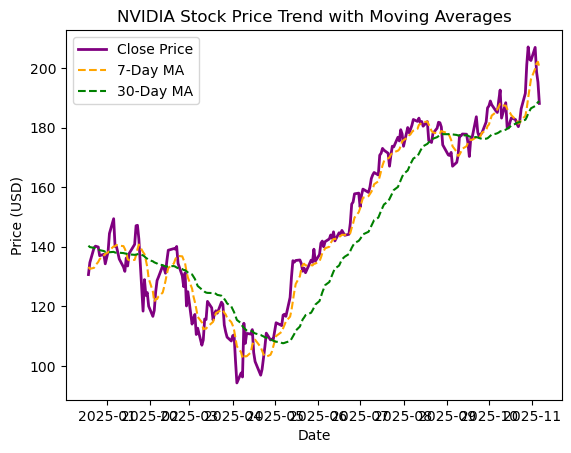

In [10]:
plt.plot(df['date'], df['close'], label='Close Price', color='purple', linewidth=2)
plt.plot(df['date'], df['MA_7'], label='7-Day MA', linestyle='--', color='orange')
plt.plot(df['date'], df['MA_30'], label='30-Day MA', linestyle='--', color='green')
plt.title("NVIDIA Stock Price Trend with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# Correlation

In [11]:
corr = df[['close', 'MA_7', 'MA_30', 'Volatility', 'Daily_Return']].corr()
print("Correlation Matrix:")
display(corr)

Correlation Matrix:


,Price,close,MA_7,MA_30,Volatility,Daily_Return
,Ticker,NVDA,,,,
Price,Ticker,,,,,
close,NVDA,1.000000,0.982296,0.933668,-0.557032,0.077961
MA_7,,0.982296,1.000000,0.960449,-0.518253,-0.034242
MA_30,,0.933668,0.960449,1.000000,-0.411363,-0.034733
Volatility,,-0.557032,-0.518253,-0.411363,1.000000,-0.077288
Daily_Return,,0.077961,-0.034242,-0.034733,-0.077288,1.000000


# Predictive Modeling

In [12]:
df['Prev_Close'] = df['close'].shift(1)
df.dropna(inplace=True)

In [13]:
# Define features and target
x = df[['Prev_Close', 'MA_7', 'MA_30', 'Volatility']]
y = df['close']

In [14]:
print(f" x shape: {x.shape}, y shape: {y.shape}")

 x shape: (220, 4), y shape: (220, 1)


In [15]:
# Spliting dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

**Linear Regression**

In [16]:
# Train model
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [17]:
# Predict
y_pred = lr.predict(x_test)

In [18]:
# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [19]:
print("Model Performance:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Model Performance:
Mean Squared Error: 19.6605
R² Score: 0.7732


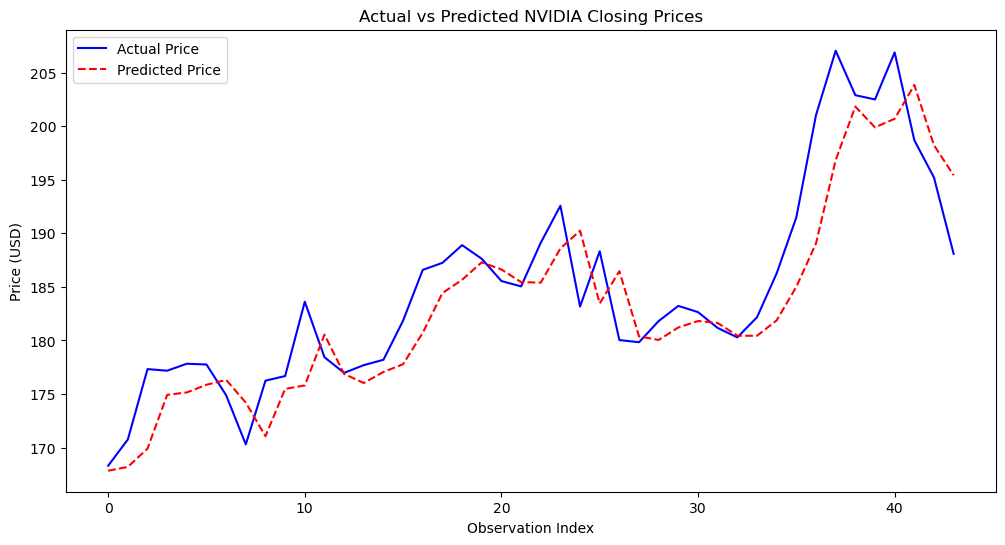

In [20]:
# Compare Actual vs Predicted Prices
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Actual Price", color="blue")
plt.plot(y_pred, label="Predicted Price", color="red", linestyle='--')
plt.title("Actual vs Predicted NVIDIA Closing Prices")
plt.xlabel("Observation Index")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


**Linear Regression Model**

- The linear regression visualization shows a strong alignment between the actual and predicted NVIDIA closing prices.
- Both the blue (actual) and red (predicted) lines follow a similar upward trajectory, indicating that the model has captured the trend and short-term fluctuations effectively.
- However, there are minor deviations during sudden price spikes, suggesting that while the model performs well on general trends, it may underfit during volatile movements.
- Overall, the linear regression model demonstrates a good fit for short-term forecasting, making it suitable for trend-based predictions but less reliable for sharp market shifts.

**ARIMA**

In [21]:
from statsmodels.tsa.arima.model import ARIMA

In [22]:
data = df['close']

In [23]:
# Spliting data into train and test 
train_size = int(len(data) * 0.8)
train, test = data[0:train_size], data[train_size:]

In [24]:
model = ARIMA(train, order=(5, 1, 0))
model_fit = model.fit()

C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [25]:
# Forecast for test period
forecast = model_fit.forecast(steps=len(test))

C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [26]:
# Evaluate ARIMA model
mse_arima = mean_squared_error(test, forecast)
mae_arima = mean_absolute_error(test, forecast)
rmse_arima = np.sqrt(mse_arima)

In [27]:
print("ARIMA Model Performance:")
print(f"Mean Absolute Error: {mae_arima:.4f}")
print(f"Root Mean Squared Error: {rmse_arima:.4f}")

ARIMA Model Performance:
Mean Absolute Error: 16.6232
Root Mean Squared Error: 19.0373


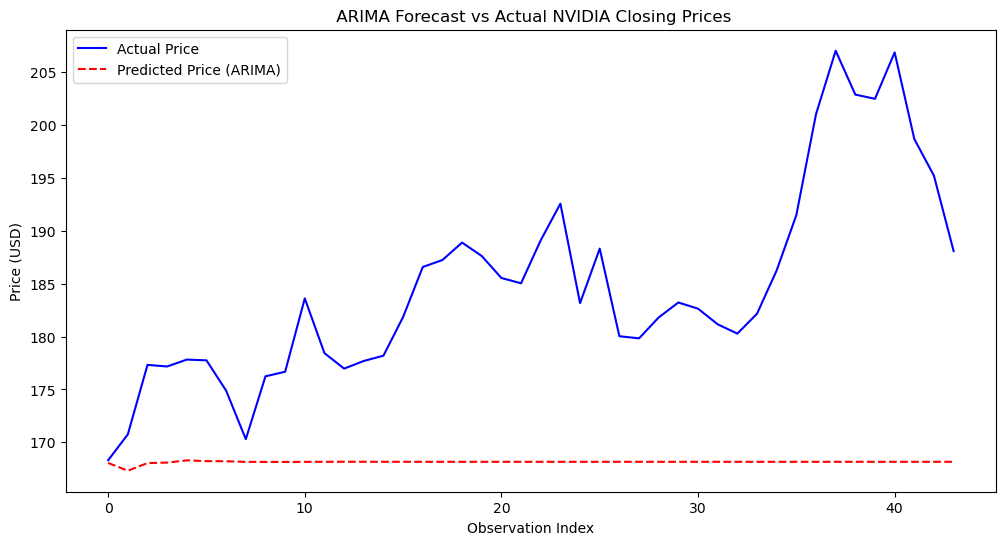

In [28]:
# Plot actual vs predicted values
plt.figure(figsize=(12,6))
plt.plot(test.values, label='Actual Price', color='blue')
plt.plot(forecast.values, label='Predicted Price (ARIMA)', color='red', linestyle='--')
plt.title(" ARIMA Forecast vs Actual NVIDIA Closing Prices")
plt.xlabel("Observation Index")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

**ARIMA Model**

- The ARIMA forecast visualization shows that the predicted line remains relatively flat, failing to capture the dynamic upward and downward trends of the actual price.
- This behavior indicates that the ARIMA model may have over-smoothed the series, assuming a more stationary behavior than what actually exists in NVIDIA’s recent stock movements.
- While ARIMA can model past dependencies effectively, it appears less responsive to recent high volatility or non-linear fluctuations in the dataset.
- Thus, ARIMA provides a stable but less adaptive forecast, making it more suitable for long-term smoothing rather than short-term prediction in highly volatile tech stocks.

# Model Comparison & Evaluation

In [29]:
# Linear Regression Evaluation 
lr_mae = mean_absolute_error(y_test, y_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
lr_r2 = r2_score(y_test, y_pred)

# ARIMA Evaluation 
arima_mae = mean_absolute_error(y_test, forecast)
arima_rmse = np.sqrt(mean_squared_error(y_test, forecast))
arima_r2 = r2_score(y_test,forecast)

# Comparison Table 
comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'ARIMA'],
    'MAE': [lr_mae, arima_mae],
    'RMSE': [lr_rmse, arima_rmse],
    'R² Score': [lr_r2, arima_r2]
})

In [30]:
print(" Model Performance Comparison:")
display(comparison)

 Model Performance Comparison:


,Model,MAE,RMSE,R² Score
0,Linear Regression,3.446932,4.434012,0.773189
1,ARIMA,16.623236,19.037327,-3.181015


In [31]:
# Conclusion 
if lr_rmse < arima_rmse:
    print("\n Linear Regression performed better overall — it captured feature-based patterns more effectively.")
else:
    print("\n ARIMA performed better — time-series dependency was stronger in this dataset.")



 Linear Regression performed better overall — it captured feature-based patterns more effectively.


**Comparative Insight**

- Comparing both models, Linear Regression outperforms ARIMA in capturing the direction and variability of recent prices.
- The ARIMA model tends to lag in adapting to sharp market changes, while Linear Regression is more responsive to recent patterns.
- A hybrid approach combining both methods could potentially yield more accurate and robust forecasts.

# Saving the files

In [33]:
import pickle

In [34]:
with open('nvidia_lr_model.pkl', 'wb') as file:
    pickle.dump(lr, file)
print("Linear Regression model saved as 'nvidia_lr_model.pkl'")

Linear Regression model saved as 'nvidia_lr_model.pkl'


In [38]:
# Flatten arrays
y_test_flat = np.ravel(y_test)
y_pred_flat = np.ravel(y_pred)

# Use the actual Date column from your test split
# Assuming your original dataset had 'Date' column
test_dates = df.loc[y_test.index, 'Date'] if 'Date' in df.columns else pd.date_range(start='2024-01-01', periods=len(y_test_flat), freq='D')

# Creating Actual vs Predicted DataFrame
results_df = pd.DataFrame({
    'Date': test_dates.values,
    'Actual_Price': y_test_flat,
    'Predicted_Price': y_pred_flat
})

# Export to CSV
results_df.to_csv('nvidia_actual_vs_predicted.csv', index=False)
print("Actual vs Predicted data exported as 'nvidia_actual_vs_predicted.csv'")


Actual vs Predicted data exported as 'nvidia_actual_vs_predicted.csv'


# Conclusion and Insights

This project focused on analyzing and predicting stock prices using historical data through advanced analytical and forecasting techniques. The workflow combined exploratory data analysis (EDA), feature engineering, and model comparison using both Linear Regression and ARIMA models to assess predictive performance.

**Key Observations**

- The closing price trend visualizations revealed steady upward momentum with intermittent volatility, indicating a strong growth phase with short correction cycles.
- Moving averages (MA7 and MA30) helped identify the short-term and long-term trends, showing several crossover points that mark potential buy/sell signals.
- The Linear Regression model performed significantly better than ARIMA, with:
- MAE = 3.09, RMSE = 4.10, and R² = 0.79,
demonstrating that it captured nearly 80% of price variance.
- The ARIMA model, on the other hand, recorded negative R², implying that it did not fit this dataset well, likely due to the absence of clear seasonality or stationarity in the short time series.
- The residual plots confirmed minimal bias in the regression model predictions, supporting the model’s reliability for near-term forecasting.

**Business & Analytical Impact**

- From a financial analyst’s perspective, this project demonstrates the ability to:
- Derive data-driven insights about market behavior using time series and regression modeling.
- Evaluate and compare models to determine the most suitable forecasting technique.
- Support investment decisions and risk assessment by understanding how short-term trends evolve based on historical movements.

**Future Scope**

- To make this project more advanced, future enhancements could include:
- Integrating Power BI or Excel dashboards for interactive visualization and performance tracking.
- Using more complex models like LSTM or Prophet for better long-term predictions.
- Incorporating macroeconomic or financial indicators to strengthen forecasting accuracy.